In [ ]:
!wget https://www.dropbox.com/s/5721wcs2guuykzl/stacksample.zip?dl=0

In [ ]:
!unzip stacksample.zip?dl=0

In [3]:
!rm stacksample.zip?dl=0

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import collections

In [5]:
df_tag=pd.read_csv('/content/Tags.csv',encoding='iso-8859-1')

In [6]:
df_tag.shape

(3750994, 2)

In [7]:
def plot_tag(tagCount):
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


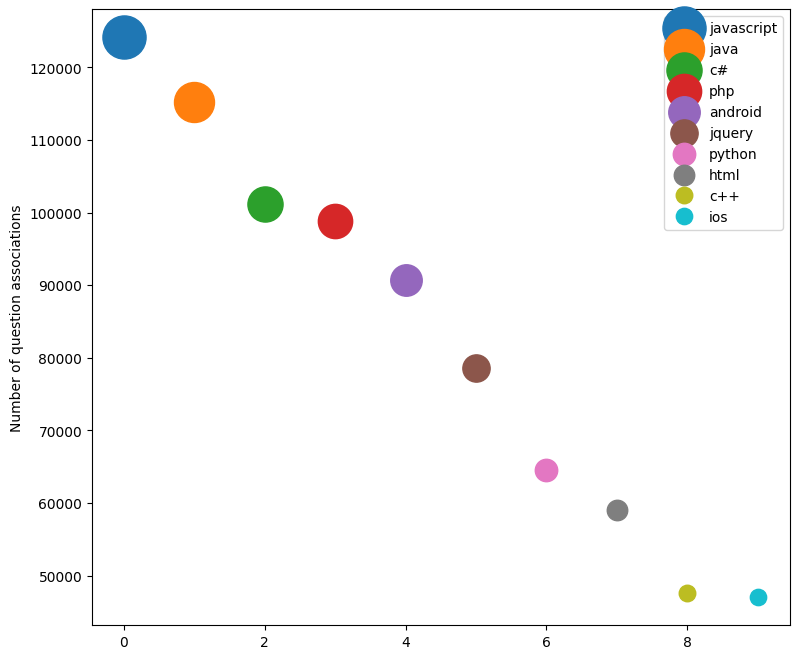

In [8]:
tagCount =  collections.Counter(list(df_tag['Tag'])).most_common(10)
print(tagCount)
plot_tag(tagCount)


In [9]:
top10=['javascript','java','c#','php','android','jquery','python','html','c++','ios']

In [10]:
tag_top10= df_tag[df_tag.Tag.isin(top10)]
print (tag_top10.shape)
tag_top10.head()

(826739, 2)


,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [11]:
tag_top10['Tag'].values

array(['c#', 'c++', 'c#', ..., 'php', 'android', 'javascript'],
      dtype=object)

In [12]:
def add_tags(question_id):
    return tag_top10[tag_top10['Id'] == question_id['Id']].Tag.values

In [13]:
top10=tag_top10.apply(add_tags,axis=1)

In [14]:
len(top10),tag_top10.shape

(826739, (826739, 2))

In [15]:
tag_top10=pd.concat([tag_top10,top10.rename('Tags')],axis=1)
tag_top10.head()

,Id,Tag,Tags
14,260,c#,[c#]
18,330,c++,[c++]
28,650,c#,[c#]
35,930,c#,[c#]
39,1010,c#,[c#]


In [16]:
tag_top10.drop(['Tag'],axis=1,inplace=True)

In [17]:
tag_top10.shape

(826739, 2)

In [18]:
top10_tag=tag_top10.loc[tag_top10.astype(str).drop_duplicates().index]

In [19]:
top10_tag['Tags'].dtype

dtype('O')

Question.CSV

In [20]:
data=pd.read_csv('/content/Questions.csv',encoding='iso-8859-1')

In [21]:
data.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [22]:
drop=['OwnerUserId','CreationDate','ClosedDate','Score']

In [23]:
data.drop(drop,axis=1,inplace=True)

In [ ]:
data

In [25]:
import re

In [26]:
def rem_html_tags(body):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', body)

In [27]:
data['Body']=data['Body'].apply(rem_html_tags)

In [28]:
data.to_csv('question_clean.csv',index=False)

Clean CSV

In [29]:
ques=pd.read_csv('/content/question_clean.csv',encoding='iso-8859-1')

In [30]:
ques.head()

,Id,Title,Body
0,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...
1,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...
2,120,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...
3,180,Function for creating color wheels,This is something I've pseudo-solved many time...
4,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...


In [31]:
total=pd.merge(ques,top10_tag,on='Id')

In [32]:
total.head()

,Id,Title,Body,Tags
0,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,[c#]
1,330,Should I use nested classes in this case?,I am working on a collection of classes used f...,[c++]
2,650,Automatically update version number,I would like the version property of my applic...,[c#]
3,930,How do I connect to a database and loop over a...,What's the simplest way to connect and query a...,[c#]
4,1010,"How to get the value of built, encoded ViewState?",I need to grab the base64-encoded representati...,[c#]


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Dense,Activation,Dropout,LSTM,Input,Embedding,BatchNormalization,GRU,concatenate
from keras.models import Model

In [34]:
multilabel_binariser=MultiLabelBinarizer()
multilabel_binariser.fit(total.Tags)
labels=multilabel_binariser.classes_
labels

array(['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript',
       'jquery', 'php', 'python'], dtype=object)

In [35]:
train,test=train_test_split(total[:550000],test_size=0.25,random_state=24)

In [36]:
train.shape,test.shape

((412500, 4), (137500, 4))

In [37]:
X_train_t=train['Title']
X_train_b=train['Body']
y_train=multilabel_binariser.transform(train['Tags'])
X_test_t=test['Title']
X_test_b=test['Body']
y_test=multilabel_binariser.transform(test['Tags'])

In [39]:
import nltk
nltk.download('punkt')  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
sent_len=[]
for sent in train['Title']:
    sent_len.append(len(word_tokenize(sent)))

In [41]:
max(sent_len),np.quantile(sent_len,0.97)

(60, 18.0)

In [ ]:
max_len=18
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_t)
sequence_train_t = tok.texts_to_sequences(X_train_t)
sequence_train_t

In [43]:
vocab_len_t=len(tok.index_word.keys())
vocab_len_t

68969

In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
sequences_matrix_train_t = pad_sequences( sequence_train_t, maxlen=18)
sequences_matrix_train_t

In [61]:
sequence_test_t=tok.texts_to_sequences(X_test_t)
sequence_matrix_test_t=pad_sequences(sequence_test_t,maxlen=max_len)

In [63]:
sequences_matrix_train_t.shape,sequence_matrix_test_t.shape,y_train.shape,y_test.shape

((412500, 18), (137500, 18), (412500, 10), (137500, 10))

In [64]:
sent_len_b=[]
for sent in train['Body']:
    sent_len_b.append(len(word_tokenize(sent)))

20868

In [65]:
max(sent_len_b),np.quantile(sent_len_b,0.90)

(20868, 578.0)

In [67]:
max_len_b=600
tok=Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_b)
sequence_train_b=tok.texts_to_sequences(X_train_b)
sequence_matrix_train_b=pad_sequences(sequence_train_b,maxlen=max_len_b)

In [68]:
vocab_len_b=len(tok.word_index.keys())
vocab_len_b

1292018

In [70]:
sequence_test_b=tok.texts_to_sequences(X_test_b)
sequence_matrix_test_b=pad_sequences(sequence_test_b,maxlen=max_len_b)

In [72]:
sequences_matrix_train_t.shape,sequence_matrix_train_b.shape,y_train.shape

((412500, 18), (412500, 600), (412500, 10))

In [74]:
sequence_matrix_test_t.shape,sequence_matrix_test_b.shape,y_test.shape

((137500, 18), (137500, 600), (137500, 10))

In [75]:
def RNN():
    title_input=Input(name='title_input',shape=[max_len])
    title_embed=Embedding(vocab_len_t+1,2000,input_length=max_len,mask_zero=True,name='Title_embed')(title_input)
    GRU_out_t=GRU(300)(title_embed)
    
    auxiliary_output=Dense(10,activation='sigmoid',name='aux_output')(GRU_out_t)
    
    body_input=Input(name='Body_input',shape=[max_len_b])
    body_embed=Embedding(vocab_len_b+1,170,input_length=max_len_b,mask_zero=True,name='Body_Embed')(body_input)
    GRU_out_b=GRU(200)(body_embed)
    
    com=concatenate(GRU_out_t,GRU_out_b)
    
    dense1=Dense(400,activation='relu')(com)
    dp1=Dropout(0.5)(dense1)
    bn=BatchNormalization()(dp1)
    dense2=Dense(150,activation='sigmoid')(bn)
    main_output=Dense(10,activation='sigmoid',name='Main_output')(dense2)
    
    model=Model(inputs=[title_input,body_input],outputs=[main_output,auxiliary_output])
    

In [ ]:
model=RNN()
model.summary()

In [ ]:
model.compile(loss={'main_output':'categorical_crossentropy','auxiliary_output':'categorical_crossentropy'},optimizer='adam'
              ,metrics=['accuracy'])

In [ ]:
results=model.fit({'title_input':sequence_marix_train_t,'body_input': sequence_matrix_train_b},
                 {'main_output':y_train,'auxiliary_output':y_train},
                 validation_data=[{'title_input':sequence_matrix_test_t,'body_input':sequence_matrix_test_b},
                 {'main_output':y_test,'auxiliary_output':y_test}],
                 epochs=5,batch_size=800)

In [ ]:
(predicted_main, predicted_aux)=model.predict({'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},verbose=1)

In [ ]:
from sklearn.metrics import Classification_report,f1_score

In [ ]:
print(f1_score(y_test,predicted_main>.55,average='samples'))

In [ ]:
print(classification_report(y_test,predicted_main>.55))

In [ ]:
test.iloc[24]

In [ ]:
model.save('./stackoverflow_tags.h5')

NameError: name 'model' is not defined